In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)
plt.style.use('ggplot')

In [2]:
## PATHS
# Inputs
in_vuelos = 'dataset_SCL.csv'

# DTypes vuelos para lectura eficiente de DF
dtypes_vuelos = {
    'Vlo-I':str,
    'Vlo-O': str,
    'DIA': int,
    'MES': int,
    'AÑO': int,
}

In [3]:
vuelos = pd.read_csv(in_vuelos, 
                     parse_dates= ['Fecha-I', 'Fecha-O'],
                    dtype= dtypes_vuelos)

In [4]:
display(vuelos.head())
display(vuelos.dtypes)
vuelos.shape

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

(68206, 18)

## 1. Exploratory Data Analysis

Solo un valor nulo para `Fecha-O` que procedo a dropear.

In [5]:
vuelos.isnull().mean()

Fecha-I      0.000000
Vlo-I        0.000000
Ori-I        0.000000
Des-I        0.000000
Emp-I        0.000000
Fecha-O      0.000000
Vlo-O        0.000015
Ori-O        0.000000
Des-O        0.000000
Emp-O        0.000000
DIA          0.000000
MES          0.000000
AÑO          0.000000
DIANOM       0.000000
TIPOVUELO    0.000000
OPERA        0.000000
SIGLAORI     0.000000
SIGLADES     0.000000
dtype: float64

In [6]:
vuelos = vuelos.dropna(subset= ['Vlo-O']).copy()

No tiene registros duplicados.

In [7]:
vuelos.drop_duplicates().shape == vuelos.shape

True

### Fechas

Los vuelos corresponden al año 2017 con una frecuencia estable, salvo por la primera semana del año. Los días sábados la cantidad de vuelos cae considerablemente con respecto al promedio.

En términos de horarios, las frecuencias de vuelos más altas se encuentran en la franja de 6 a 9, mientras que las más bajas se encuentran por la madrugada de 23 a 4.

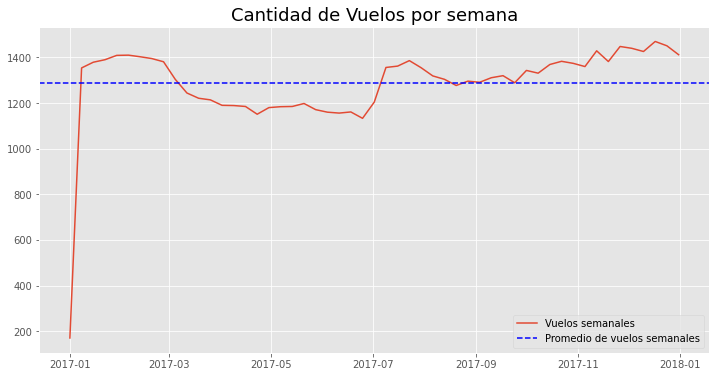

In [8]:
plt.figure(figsize= (12, 6))
plt.plot(vuelos.set_index('Fecha-I').resample('W')['DIA'].count(),
        label= 'Vuelos semanales')
plt.axhline(vuelos.set_index('Fecha-I').resample('W')['DIA'].count().mean(),
           c= 'b',
           ls= '--',
           label= 'Promedio de vuelos semanales')

plt.title('Cantidad de Vuelos por semana', fontsize= 18)
plt.legend()
plt.show()

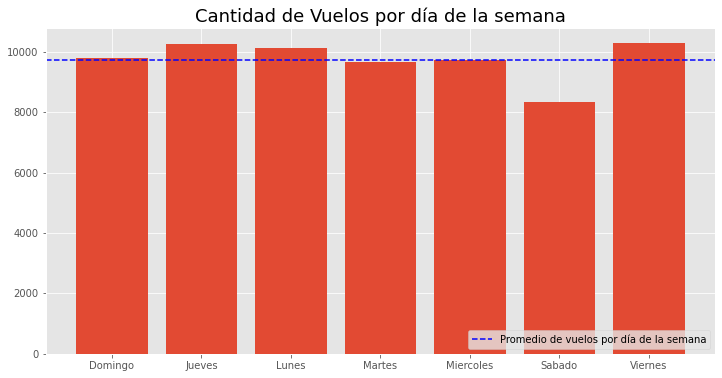

In [9]:
plt.figure(figsize= (12, 6))
plt.bar(vuelos.groupby('DIANOM')['DIA'].count().index, height= vuelos.groupby('DIANOM')['DIA'].count().values)
plt.axhline(vuelos['DIANOM'].value_counts().mean(),
           c= 'b',
           ls= '--',
           label= 'Promedio de vuelos por día de la semana')

plt.title('Cantidad de Vuelos por día de la semana', fontsize= 18)
plt.legend(loc='lower right')
plt.show()

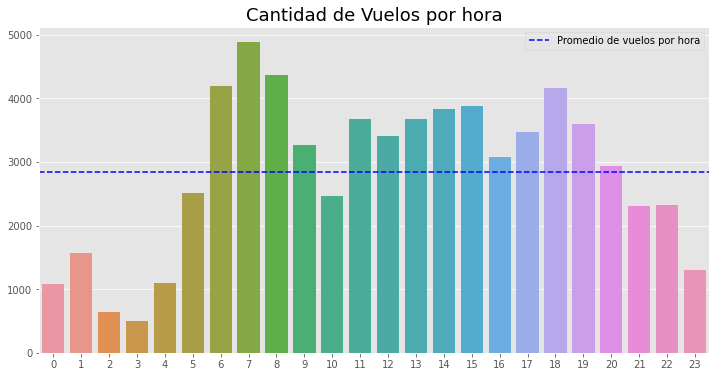

In [10]:
plt.figure(figsize= (12, 6))
horarios_count = vuelos['Fecha-I'].dt.hour.value_counts().sort_index()
sns.barplot(x= horarios_count.index, y= horarios_count.values)
plt.axhline(horarios_count.mean(),
           c= 'b',
           ls= '--',
           label= 'Promedio de vuelos por hora')
plt.title('Cantidad de Vuelos por hora', fontsize= 18)
plt.legend()
plt.show();

### Destinos

La gran mayoría de los destintos tiene menos de 500 viajes en el año, los destinos más populares teniendo entre el 8% y el 4% del total de viajes.

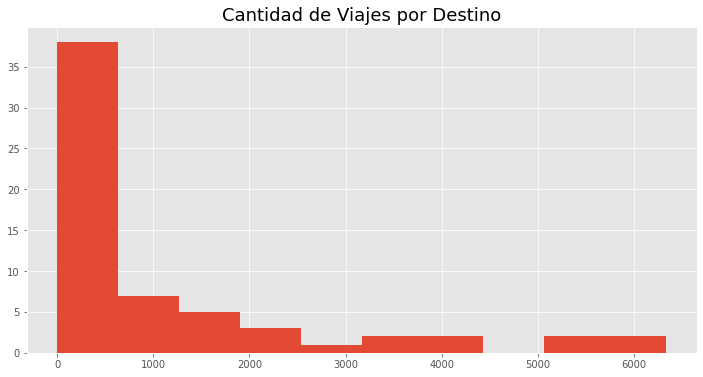

In [11]:
plt.figure(figsize= (12, 6))
vuelos['SIGLADES'].value_counts().hist()
plt.title('Cantidad de Viajes por Destino', fontsize= 18);

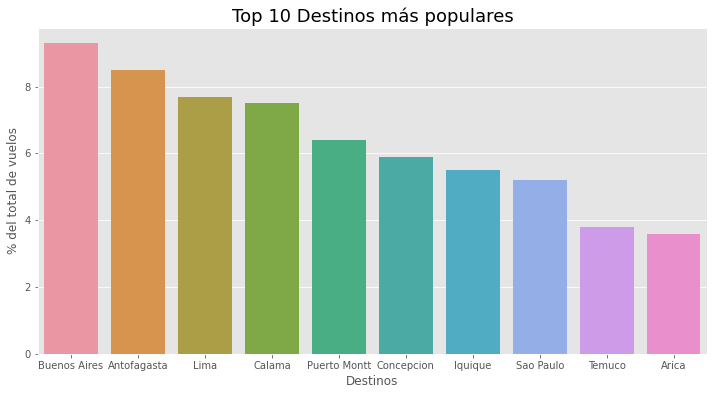

In [12]:
destino_count = np.round(vuelos['SIGLADES'].value_counts(normalize= True).head(10) * 100, 1)
plt.figure(figsize= (12, 6))
sns.barplot(x= destino_count.index, y= destino_count.values)
plt.ylabel('% del total de vuelos')
plt.xlabel('Destinos')
plt.title('Top 10 Destinos más populares', fontsize= 18);

#### Se podrían hacer analisis más exhaustivos sobre las empresas que operan el servicio y los tipos de vuelos que desarrollan.

## 2. Columnas Adicionales

Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv

- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .


### temporada_alta

In [23]:
vuelos['temporada_alta'] = (vuelos['Fecha-I'].between('2017-12-15', '2017-12-31') | \
vuelos['Fecha-I'].between('2017-01-01', '2017-03-03') | \
vuelos['Fecha-I'].between('2017-07-15', '2017-07-31') | \
vuelos['Fecha-I'].between('2017-09-11', '2017-09-30')).astype('int8')

### dif_min

In [40]:
vuelos['dif_min'] = (vuelos['Fecha-O'] - vuelos['Fecha-I']).dt.total_seconds() / 60

### atraso_15

In [43]:
vuelos['atraso_15'] = (vuelos['dif_min'] > 15).astype('int8')

### periodo_dia

In [66]:
vuelos['periodo_dia'] = ''

vuelos.loc[vuelos['Fecha-I'].dt.hour.between(5, 11), 'periodo_dia'] = 'mañana'
vuelos.loc[vuelos['Fecha-I'].dt.hour.between(12, 18), 'periodo_dia'] = 'tarde'
vuelos.loc[vuelos['Fecha-I'].dt.hour.between(19, 4), 'periodo_dia'] = 'noche'

In [13]:
###

# Vuelos con distinto inicio y final
# Feriados